In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from itertools import cycle
import re

plt.rc("ytick.major", size=5, width=1)
plt.rcParams["text.usetex"] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 22
plt.rcParams["axes.labelsize"] = 22

In [2]:
df_s = pd.read_csv("threadFenceReduction_single.txt")
df_m = pd.read_csv("threadFenceReduction_multi.txt")

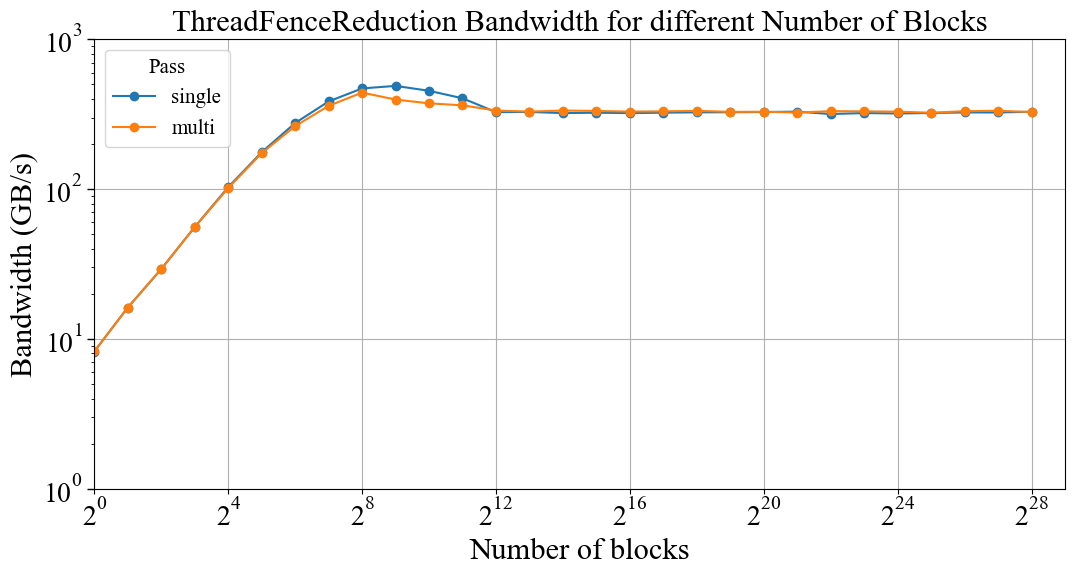

In [28]:
plt.figure(figsize=(11, 6))
plt.plot(df_s["i"], df_s["bw"], label="single", marker="o")
plt.plot(df_m["i"], df_m["bw"], label="multi", marker="o")
plt.xscale("log", base=2)
plt.yscale("log")
plt.ylim(1, 1000)
plt.xlim(2**(0),2**29)
plt.xlabel("Number of blocks")
plt.ylabel("Bandwidth (GB/s)")
plt.title("ThreadFenceReduction Bandwidth for different Number of Blocks")
plt.legend(title="Pass")
plt.grid(which="major")
plt.tight_layout()
plt.savefig("threadFenceReduction.pdf", bbox_inches="tight")
plt.show()